In [8]:
%matplotlib widget

import numpy as np
import scipy
import matplotlib.pyplot as plt

from receiver import ReceiverBLE, Receiver802154
from filters import simple_squelch, add_white_gaussian_noise, decimating_fir_filter
from demodulation import demodulate_frequency, symbol_sync, binary_slicer
from data_io import read_iq_data
from visualisation import plot_complex_time, plot_periodograms, plot_payload

plt.close('all')

# Testing matched filtering on demodulation process

In [9]:
# Try custom demodulate() method from Receiver classes, where instead of using a low pass filter (with 200 taps!),
# a matched filter is used borrowed from the modulation process (use the same taps that are used for modulation)

# Evaluate the frequency response of the FIR taps (using periodogram plots!)

# Plot each step of the demodulation process within the demodulation() method (IQ time and periodogram)
# Evaluate how the differentiator works as a filter

# Once the matched filter is working properly try with additive noise (like examples in test_802154.ipynb)
# Understand why the null to null bandwidth of BLE is 1.5MHz, and for IEEE 802.15.4 is 3MHz

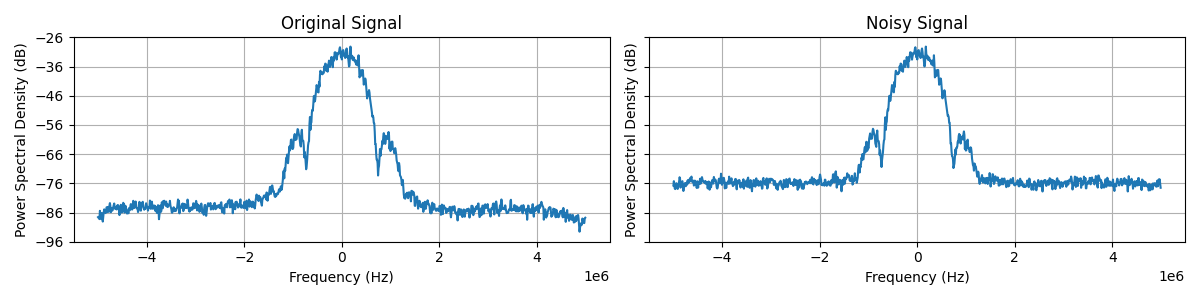

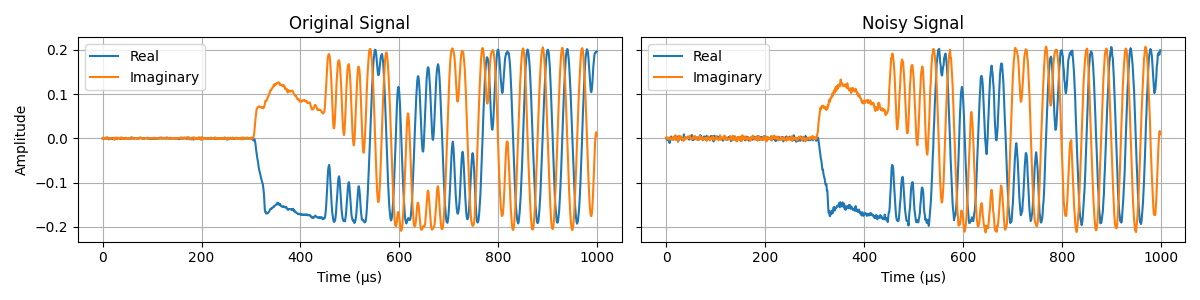

In [10]:
fs = 10e6  # Hz
sps = 10
filename = "BLE_0dBm.dat"  # Open BLE file
# filename = "802154_0dBm.dat"  # Open BLE file
iq_samples = read_iq_data(f"../capture_nRF/data/new/{filename}")
fsk_deviation_ble: float = 250e3  # Hz

noise_power = -45
iq_samples_noisy = add_white_gaussian_noise(iq_samples, noise_power)

# figsize = (12, 3)
plot_periodograms(
    [iq_samples, iq_samples_noisy],
    fs=fs,
    titles=["Original Signal", "Noisy Signal"],
    figsize=(12, 3),
    NFFT=1024,
    horizontal=True,
)
time_interval = (3000, 4000)
plot_complex_time(
    [iq_samples[time_interval[0] : time_interval[1]], iq_samples_noisy[time_interval[0] : time_interval[1]]],
    fs=fs,
    titles=["Original Signal", "Noisy Signal"],
    figsize=(12, 3),
    horizontal=True,
)

## Demodulation process at receiver

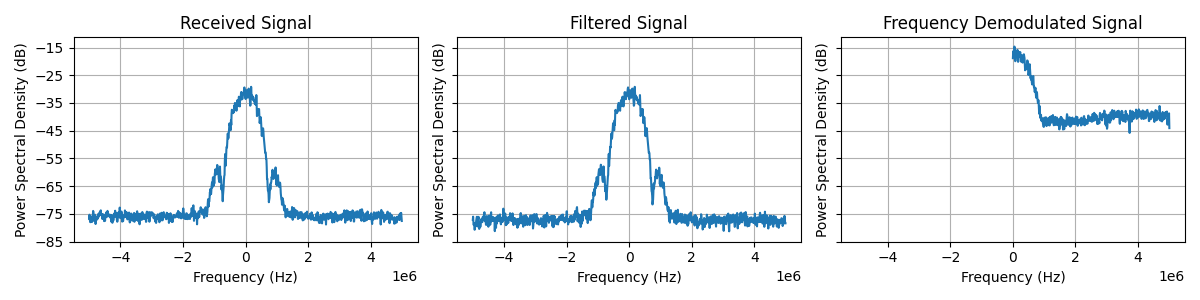

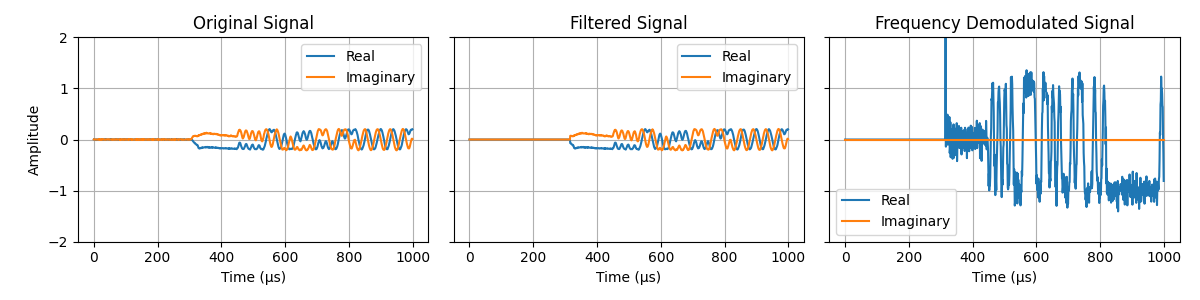

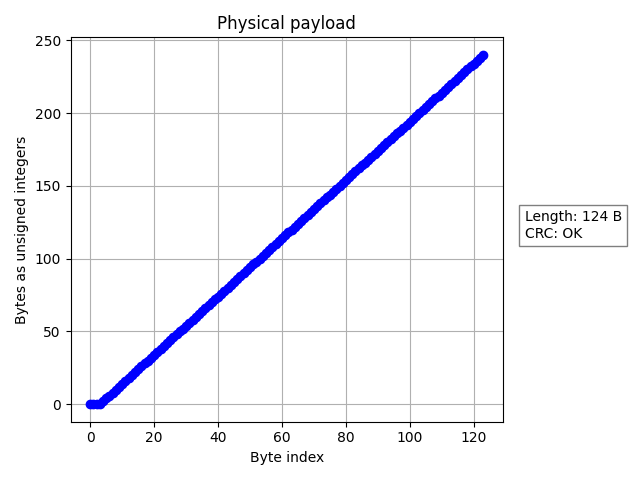

In [11]:
butterworth_filter = False
if butterworth_filter:
    # Low pass filter
    iq_samples_filtered = decimating_fir_filter(
        iq_samples_noisy,
        decimation=1,
        gain=1,
        fs=fs,
        cutoff_freq=1e6,
        transition_width=100003,
        window="hamming",
    )
else:
    iq_samples_filtered = iq_samples_noisy

# Squelch
squelch_threshold = 1e-1
iq_samples_filtered = simple_squelch(iq_samples_filtered, threshold=squelch_threshold)

# Frequency demodulation
freq_samples = demodulate_frequency(iq_samples_filtered, gain=(fs) / (2 * np.pi * fsk_deviation_ble))

# Symbol synchronisation
bit_samples = symbol_sync(freq_samples, sps=sps)
bit_samples = binary_slicer(bit_samples)
receiver_ble = ReceiverBLE(fs=fs, decimation=1)
# bit_samples = receiver_ble.demodulate(iq_samples)

received_packets: list[dict] = receiver_ble.process_phy_packet(bit_samples)
if received_packets:
    plot_payload(received_packets[0])

plot_periodograms(
    [
        iq_samples_noisy,
        iq_samples_filtered,
        freq_samples,
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal",
        "Frequency Demodulated Signal",
    ],
    figsize=(12, 3),
    NFFT=1024,
    horizontal=True,
)

plot_complex_time(
    [
        iq_samples_noisy[time_interval[0] : time_interval[1]],
        iq_samples_filtered[time_interval[0] : time_interval[1]],
        freq_samples[time_interval[0] : time_interval[1]],
    ],
    fs=fs,
    titles=[
        "Original Signal",
        "Filtered Signal",
        "Frequency Demodulated Signal",
    ],
    figsize=(12, 3),
    ylim=(-2, 2),
    horizontal=True,
)

In [ ]:
# TODO:
# Apply Gaussian FIR taps after frequency demodulation
# Apply matched filtering based on band-pass filtering (complex correlation with complex matched filter)